In [1]:
import gc
from itertools import combinations
import pathlib
from typing import Any, Dict, List
import warnings
import yaml

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import polars as pl
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

gc.enable()
pd.set_option('display.max_columns', 200)
warnings.simplefilter('ignore')

In [2]:
def reduce_mem_usage(df, verbose=0):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
               
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float32)
    if verbose:
        logger.info(f"Memory usage of dataframe is {start_mem:.2f} MB")
        end_mem = df.memory_usage().sum() / 1024**2
        logger.info(f"Memory usage after optimization is: {end_mem:.2f} MB")
        decrease = 100 * (start_mem - end_mem) / start_mem
        logger.info(f"Decreased by {decrease:.2f}%")
    return df

In [3]:
from numba import njit, prange


@njit(parallel=True)
def compute_triplet_imbalance(df_values, comb_indices):
    num_rows = df_values.shape[0]
    num_combinations = len(comb_indices)
    imbalance_features = np.empty((num_rows, num_combinations))
    for i in prange(num_combinations):
        a, b, c = comb_indices[i]
        for j in range(num_rows):
            max_val = max(df_values[j, a], df_values[j, b], df_values[j, c])
            min_val = min(df_values[j, a], df_values[j, b], df_values[j, c])
            mid_val = df_values[j, a] + df_values[j, b] + df_values[j, c] - min_val - max_val
            
            if mid_val == min_val:
                imbalance_features[j, i] = np.nan
            else:
                imbalance_features[j, i] = (max_val - mid_val) / (mid_val - min_val)

    return imbalance_features

def calculate_triplet_imbalance_numba(price, df):
    df_values = df[price].values
    comb_indices = [(price.index(a), price.index(b), price.index(c)) for a, b, c in combinations(price, 3)]
    features_array = compute_triplet_imbalance(df_values, comb_indices)
    columns = [f"{a}_{b}_{c}_imb2" for a, b, c in combinations(price, 3)]
    features = pd.DataFrame(features_array, columns=columns)
    return features

In [4]:
def imbalance_features(df):
    # Define lists of price and size-related column names
    prices = ["reference_price", "far_price", "near_price", "ask_price", "bid_price", "wap"]
    sizes = ["matched_size", "bid_size", "ask_size", "imbalance_size"]
    
    df["volume"] = df.eval("ask_size + bid_size")
    df["mid_price"] = df.eval("(ask_price + bid_price) / 2")
    df["liquidity_imbalance"] = df.eval("(bid_size-ask_size)/(bid_size+ask_size)")
    df["matched_imbalance"] = df.eval("(imbalance_size-matched_size)/(matched_size+imbalance_size)")
    df["size_imbalance"] = df.eval("bid_size / ask_size")

    for c in combinations(prices, 2):
        df[f"{c[0]}_{c[1]}_imb"] = df.eval(f"({c[0]} - {c[1]})/({c[0]} + {c[1]})")

    for c in [['ask_price', 'bid_price', 'wap', 'reference_price'], sizes]:
        triplet_feature = calculate_triplet_imbalance_numba(c, df)
        df[triplet_feature.columns] = triplet_feature.values
    
    df["stock_weights"] = df["stock_id"].map(weights)
    df["weighted_wap"] = df["stock_weights"] * df["wap"]
    df['wap_momentum'] = df.groupby('stock_id')['weighted_wap'].pct_change(periods=6)
   
    df["imbalance_momentum"] = df.groupby(['stock_id'])['imbalance_size'].diff(periods=1) / df['matched_size']
    df["price_spread"] = df["ask_price"] - df["bid_price"]
    df["spread_intensity"] = df.groupby(['stock_id'])['price_spread'].diff()
    df['price_pressure'] = df['imbalance_size'] * (df['ask_price'] - df['bid_price'])
    df['market_urgency'] = df['price_spread'] * df['liquidity_imbalance']
    df['depth_pressure'] = (df['ask_size'] - df['bid_size']) * (df['far_price'] - df['near_price'])
    
    df['spread_depth_ratio'] = (df['ask_price'] - df['bid_price']) / (df['bid_size'] + df['ask_size'])
    df['mid_price_movement'] = df['mid_price'].diff(periods=5).apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
    
    df['micro_price'] = ((df['bid_price'] * df['ask_size']) + (df['ask_price'] * df['bid_size'])) / (df['bid_size'] + df['ask_size'])
    df['relative_spread'] = (df['ask_price'] - df['bid_price']) / df['wap']
    
    # Calculate various statistical aggregation features
    for func in ["mean", "std", "skew", "kurt"]:
        df[f"all_prices_{func}"] = df[prices].agg(func, axis=1)
        df[f"all_sizes_{func}"] = df[sizes].agg(func, axis=1)
        

    for col in ['matched_size', 'imbalance_size', 'reference_price', 'imbalance_buy_sell_flag']:
        for window in [1,3,5,10]:
            df[f"{col}_shift_{window}"] = df.groupby('stock_id')[col].shift(window)
            df[f"{col}_ret_{window}"] = df.groupby('stock_id')[col].pct_change(window)
    
    # Calculate diff features for specific columns
    for col in ['ask_price', 'bid_price', 'ask_size', 'bid_size', 'weighted_wap','price_spread']:
        for window in [1,3,5,10]:
            df[f"{col}_diff_{window}"] = df.groupby("stock_id")[col].diff(window)
    
    #V4 feature
    for window in [3,5,10]:
        df[f'price_change_diff_{window}'] = df[f'bid_price_diff_{window}'] - df[f'ask_price_diff_{window}']
        df[f'size_change_diff_{window}'] = df[f'bid_size_diff_{window}'] - df[f'ask_size_diff_{window}']

    #V5 - rolling diff
    # Convert from pandas to Polars
    pl_df = pl.from_pandas(df)

    #Define the windows and columns for which you want to calculate the rolling statistics
    windows = [3, 5, 10]
    columns = ['ask_price', 'bid_price', 'ask_size', 'bid_size']

    # prepare the operations for each column and window
    group = ["stock_id"]
    expressions = []

    # Loop over each window and column to create the rolling mean and std expressions
    for window in windows:
        for col in columns:
            rolling_mean_expr = (
                pl.col(f"{col}_diff_{window}")
                .rolling_mean(window)
                .over(group)
                .alias(f'rolling_diff_{col}_{window}')
            )

            rolling_std_expr = (
                pl.col(f"{col}_diff_{window}")
                .rolling_std(window)
                .over(group)
                .alias(f'rolling_std_diff_{col}_{window}')
            )

            expressions.append(rolling_mean_expr)
            expressions.append(rolling_std_expr)

    # Run the operations using Polars' lazy API
    lazy_df = pl_df.lazy().with_columns(expressions)

    # Execute the lazy expressions and overwrite the pl_df variable
    pl_df = lazy_df.collect()

    # Convert back to pandas if necessary
    df = pl_df.to_pandas()
    del lazy_df
    gc.collect()
    
    df['mid_price*volume'] = df['mid_price_movement'] * df['volume']
    df['harmonic_imbalance'] = df.eval('2 / ((1 / bid_size) + (1 / ask_size))')
    
    for col in df.columns:
        df[col] = df[col].replace([np.inf, -np.inf], 0)

    return df

def other_features(df):
    df["dow"] = df["date_id"] % 5  # Day of the week
    df["seconds"] = df["seconds_in_bucket"] % 60  
    df["minute"] = df["seconds_in_bucket"] // 60  
    df['time_to_market_close'] = 540 - df['seconds_in_bucket']
    
    for key, value in global_stock_id_feats.items():
        df[f"global_{key}"] = df["stock_id"].map(value.to_dict())
    
    return df

def generate_all_features(df):
    # Select relevant columns for feature generation
    cols = [c for c in df.columns if c not in ["row_id", "time_id", "target"]]
    target = df['target']
    df = df[cols]
    
    # Generate imbalance features
    df = imbalance_features(df)
    gc.collect() 
    df = other_features(df)
    gc.collect()  
    feature_name = [i for i in df.columns if i not in ["row_id", "time_id"]]
    
    return df[feature_name]

In [5]:
inputs_dir_path = pathlib.Path('../inputs')
outputs_dir_path = pathlib.Path('../outputs')
if not outputs_dir_path.is_dir():
    outputs_dir_path.mkdir()

train_df = pd.read_csv(inputs_dir_path. joinpath('train.csv'))
train_df.drop(columns=['row_id', 'time_id'], inplace=True)
#train_df.dropna(subset=['target'], inplace=True)
train_target = train_df['target']
display(train_df)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target
0,0,0,0,3180602.69,1,0.999812,1.338028e+07,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704
1,1,0,0,166603.91,-1,0.999896,1.642214e+06,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986
2,2,0,0,302879.87,-1,0.999561,1.819368e+06,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950
3,3,0,0,11917682.27,-1,1.000171,1.838975e+07,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200
4,4,0,0,447549.96,-1,0.999532,1.786061e+07,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4566975,195,419,540,0.00,0,1.000094,3.014272e+07,1.000094,1.000094,0.999984,49525.76,1.000094,118182.90,1.000017,7.929802
4566976,196,419,540,0.00,0,0.999542,7.882143e+06,0.999542,0.999542,0.999542,141897.36,0.999799,191049.75,0.999652,0.580549
4566977,197,419,540,272061.71,1,1.002217,6.730665e+06,1.002640,1.002429,1.002112,149357.25,1.002217,85640.52,1.002179,5.960464
4566978,198,419,540,549716.46,1,1.001793,1.058892e+08,1.002058,1.002058,1.001528,830852.33,1.001793,187152.66,1.001744,2.410412


In [6]:
weights = [
    0.004, 0.001, 0.002, 0.006, 0.004, 0.004, 0.002, 0.006, 0.006, 0.002, 0.002, 0.008,
    0.006, 0.002, 0.008, 0.006, 0.002, 0.006, 0.004, 0.002, 0.004, 0.001, 0.006, 0.004,
    0.002, 0.002, 0.004, 0.002, 0.004, 0.004, 0.001, 0.001, 0.002, 0.002, 0.006, 0.004,
    0.004, 0.004, 0.006, 0.002, 0.002, 0.04 , 0.002, 0.002, 0.004, 0.04 , 0.002, 0.001,
    0.006, 0.004, 0.004, 0.006, 0.001, 0.004, 0.004, 0.002, 0.006, 0.004, 0.006, 0.004,
    0.006, 0.004, 0.002, 0.001, 0.002, 0.004, 0.002, 0.008, 0.004, 0.004, 0.002, 0.004,
    0.006, 0.002, 0.004, 0.004, 0.002, 0.004, 0.004, 0.004, 0.001, 0.002, 0.002, 0.008,
    0.02 , 0.004, 0.006, 0.002, 0.02 , 0.002, 0.002, 0.006, 0.004, 0.002, 0.001, 0.02,
    0.006, 0.001, 0.002, 0.004, 0.001, 0.002, 0.006, 0.006, 0.004, 0.006, 0.001, 0.002,
    0.004, 0.006, 0.006, 0.001, 0.04 , 0.006, 0.002, 0.004, 0.002, 0.002, 0.006, 0.002,
    0.002, 0.004, 0.006, 0.006, 0.002, 0.002, 0.008, 0.006, 0.004, 0.002, 0.006, 0.002,
    0.004, 0.006, 0.002, 0.004, 0.001, 0.004, 0.002, 0.004, 0.008, 0.006, 0.008, 0.002,
    0.004, 0.002, 0.001, 0.004, 0.004, 0.004, 0.006, 0.008, 0.004, 0.001, 0.001, 0.002,
    0.006, 0.004, 0.001, 0.002, 0.006, 0.004, 0.006, 0.008, 0.002, 0.002, 0.004, 0.002,
    0.04 , 0.002, 0.002, 0.004, 0.002, 0.002, 0.006, 0.02 , 0.004, 0.002, 0.006, 0.02,
    0.001, 0.002, 0.006, 0.004, 0.006, 0.004, 0.004, 0.004, 0.004, 0.002, 0.004, 0.04,
    0.002, 0.008, 0.002, 0.004, 0.001, 0.004, 0.006, 0.004,
]
weights = {int(k):v for k,v in enumerate(weights)}

In [7]:
is_train = True
is_offline = False

if is_train:
    global_stock_id_feats = {
        "median_size": train_df.groupby("stock_id")["bid_size"].median() + train_df.groupby("stock_id")["ask_size"].median(),
        "std_size": train_df.groupby("stock_id")["bid_size"].std() + train_df.groupby("stock_id")["ask_size"].std(),
        "ptp_size": train_df.groupby("stock_id")["bid_size"].max() - train_df.groupby("stock_id")["bid_size"].min(),
        "median_price": train_df.groupby("stock_id")["bid_price"].median() + train_df.groupby("stock_id")["ask_price"].median(),
        "std_price": train_df.groupby("stock_id")["bid_price"].std() + train_df.groupby("stock_id")["ask_price"].std(),
        "ptp_price": train_df.groupby("stock_id")["bid_price"].max() - train_df.groupby("stock_id")["ask_price"].min(),
    }
    if is_offline:
        train_df_feats = generate_all_features(train_df)
        print("Build Train Feats Finished.")
        df_valid_feats = generate_all_features(df_valid)
        print("Build Valid Feats Finished.")
        df_valid_feats = reduce_mem_usage(df_valid_feats)
    else:
        train_df = generate_all_features(train_df)
        print("Build Online Train Feats Finished.")

    train_df = reduce_mem_usage(train_df)
    train_df = pd.concat([train_df, train_target], axis=1)
    
    del train_target
    gc.collect()

Build Online Train Feats Finished.


In [8]:
display(train_df)
train_df.dropna(subset=['target'], inplace=True)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,volume,mid_price,liquidity_imbalance,matched_imbalance,size_imbalance,reference_price_far_price_imb,reference_price_near_price_imb,reference_price_ask_price_imb,reference_price_bid_price_imb,reference_price_wap_imb,far_price_near_price_imb,far_price_ask_price_imb,far_price_bid_price_imb,far_price_wap_imb,near_price_ask_price_imb,near_price_bid_price_imb,near_price_wap_imb,ask_price_bid_price_imb,ask_price_wap_imb,bid_price_wap_imb,ask_price_bid_price_wap_imb2,ask_price_bid_price_reference_price_imb2,ask_price_wap_reference_price_imb2,bid_price_wap_reference_price_imb2,matched_size_bid_size_ask_size_imb2,matched_size_bid_size_imbalance_size_imb2,matched_size_ask_size_imbalance_size_imb2,bid_size_ask_size_imbalance_size_imb2,stock_weights,weighted_wap,wap_momentum,imbalance_momentum,price_spread,spread_intensity,price_pressure,market_urgency,depth_pressure,spread_depth_ratio,mid_price_movement,micro_price,relative_spread,all_prices_mean,all_sizes_mean,all_prices_std,all_sizes_std,all_prices_skew,all_sizes_skew,all_prices_kurt,all_sizes_kurt,matched_size_shift_1,matched_size_ret_1,matched_size_shift_3,matched_size_ret_3,matched_size_shift_5,matched_size_ret_5,matched_size_shift_10,matched_size_ret_10,imbalance_size_shift_1,imbalance_size_ret_1,imbalance_size_shift_3,imbalance_size_ret_3,imbalance_size_shift_5,imbalance_size_ret_5,imbalance_size_shift_10,imbalance_size_ret_10,reference_price_shift_1,reference_price_ret_1,reference_price_shift_3,reference_price_ret_3,reference_price_shift_5,reference_price_ret_5,reference_price_shift_10,reference_price_ret_10,imbalance_buy_sell_flag_shift_1,imbalance_buy_sell_flag_ret_1,imbalance_buy_sell_flag_shift_3,imbalance_buy_sell_flag_ret_3,imbalance_buy_sell_flag_shift_5,imbalance_buy_sell_flag_ret_5,imbalance_buy_sell_flag_shift_10,imbalance_buy_sell_flag_ret_10,ask_price_diff_1,ask_price_diff_3,ask_price_diff_5,ask_price_diff_10,bid_price_diff_1,bid_price_diff_3,bid_price_diff_5,bid_price_diff_10,ask_size_diff_1,ask_size_diff_3,ask_size_diff_5,ask_size_diff_10,bid_size_diff_1,bid_size_diff_3,bid_size_diff_5,bid_size_diff_10,weighted_wap_diff_1,weighted_wap_diff_3,weighted_wap_diff_5,weighted_wap_diff_10,price_spread_diff_1,price_spread_diff_3,price_spread_diff_5,price_spread_diff_10,price_change_diff_3,size_change_diff_3,price_change_diff_5,size_change_diff_5,price_change_diff_10,size_change_diff_10,rolling_diff_ask_price_3,rolling_std_diff_ask_price_3,rolling_diff_bid_price_3,rolling_std_diff_bid_price_3,rolling_diff_ask_size_3,rolling_std_diff_ask_size_3,rolling_diff_bid_size_3,rolling_std_diff_bid_size_3,rolling_diff_ask_price_5,rolling_std_diff_ask_price_5,rolling_diff_bid_price_5,rolling_std_diff_bid_price_5,rolling_diff_ask_size_5,rolling_std_diff_ask_size_5,rolling_diff_bid_size_5,rolling_std_diff_bid_size_5,rolling_diff_ask_price_10,rolling_std_diff_ask_price_10,rolling_diff_bid_price_10,rolling_std_diff_bid_price_10,rolling_diff_ask_size_10,rolling_std_diff_ask_size_10,rolling_diff_bid_size_10,rolling_std_diff_bid_size_10,mid_price*volume,harmonic_imbalance,dow,seconds,minute,time_to_market_close,global_median_size,global_std_size,global_ptp_size,global_median_price,global_std_price,global_ptp_price,target
0,0,0,0,3.180603e+06,1,0.999812,1.338028e+07,NaN,NaN,0.999812,60651.500000,1.000026,8493.030273,1.000000,6.914453e+04,0.999919,0.754340,-0.615890,7.141326,NaN,NaN,-0.000107,0.000000,-0.000094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000107,0.000013,-9.400884e-05,0.138298,-1.927541e+12,1.382979e-01,-1.693354e+12,255.368408,3.269177,3.215423,59.816769,0.004,0.004000,NaN,NaN,0.000214,NaN,680.648987,0.000161,NaN,3.094967e-09,0,1.000000,0.000214,0.999913,4.157506e+06,0.000117,6.324881e+06,0.042932,1.695159,0.000000,2.775961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

## train lightgbm models using cross validation

In [9]:
def train(
        dataset: pd.DataFrame,
        model_params: Dict[str, Any],
        outputs_dir: pathlib.Path,
        step: int,
        gap: int,
    ):
    
    target_columns = ['stock_id', 'date_id', 'seconds_in_bucket', 'target']
    feature_columns = [col for col in dataset.columns if col not in ['date_id', 'target']]
    days= np.arange(dataset['date_id'].min(), dataset['date_id'].max())
    fimps = []
    history = {
        'train_mae': [],
        'valid_mae': [],
    }
    oof_true = []
    oof_pred = []

    train_day_lower_limits = np.arange(0, 360, step+gap)

    mean_best_iteration = 0

    num_folds = 5
    fold_size = 480 // num_folds
    gap = 5

    date_ids = dataset['date_id']

    for i in range(num_folds):
        start = i * fold_size
        end = start + fold_size
        if i < num_folds - 1:  # No need to purge after the last fold
            purged_start = end - 2
            purged_end = end + gap + 2
            train_indices = (date_ids >= start) & (date_ids < purged_start) | (date_ids > purged_end)
        else:
            train_indices = (date_ids >= start) & (date_ids < end)

        valid_indices = (date_ids >= end) & (date_ids < end + fold_size)

        _, ax = plt.subplots()
        ax.plot(date_ids[train_indices], np.ones(sum(train_indices)), marker='o')
        ax.plot(date_ids[valid_indices], np.zeros(sum(valid_indices)), marker='o')
        ax.set_xlim(0, 480)
        plt.show()
        
        train_X = dataset.loc[train_indices][feature_columns]
        train_y = dataset.loc[train_indices][target_columns]
        valid_X = dataset.loc[valid_indices][feature_columns]
        valid_y = dataset.loc[valid_indices][target_columns]
        print(f'train_X.shape: {train_X.shape}, train_y.shape: {train_y.shape}')
        print(f'valid_X.shape: {valid_X.shape}, valid_y.shape: {valid_y.shape}')

        callbacks = [
            lgb.early_stopping(stopping_rounds=100, verbose=True),
            lgb.log_evaluation(500),
        ]
        
        train_dataset = lgb.Dataset(
            train_X,
            train_y['target'],
            #categorical_feature=['imbalance_buy_sell_flag'],
        )

        valid_dataset = lgb.Dataset(
            valid_X,
            valid_y['target'],
            #categorical_feature=['imbalance_buy_sell_flag'],
        )
        
        model = lgb.train(
            params=model_params,
            train_set=train_dataset,
            valid_sets=[train_dataset, valid_dataset],
            valid_names=['train', 'valid'],
            callbacks=callbacks,
            num_boost_round=6000,
        )
        model.save_model(
            outputs_dir.joinpath(f'lightgbm_fold{i+1}.txt'),
            num_iteration=model.best_iteration
        )
        
        fimp = model.feature_importance(importance_type='gain')
        fimp = pd.DataFrame(fimp, index=feature_columns, columns=[f'fold{i+1}'])
        fimps.append(fimp)

        train_pred = model.predict(train_X, num_iteration=model.best_iteration)
        valid_pred = model.predict(valid_X, num_iteration=model.best_iteration)

        oof_true.append(valid_y['target'])
        oof_pred.append(valid_pred)

        history['train_mae'].append(mean_absolute_error(train_y['target'], train_pred))
        history['valid_mae'].append(mean_absolute_error(valid_y['target'], valid_pred))

        mean_best_iteration += model.best_iteration
        
        del train_X, train_y, train_dataset, valid_X, valid_y, valid_dataset, model, fimp
        del train_pred, valid_pred
        gc.collect()

    history = pd.DataFrame.from_dict(history)

    mean_best_iteration /= len(train_day_lower_limits)
    
    fimps = pd.concat(fimps, axis=1)
    mean_fimps = fimps.mean(axis=1)
    std_fimps = fimps.std(axis=1)
    fimps['mean_fimps'] = mean_fimps
    fimps['std_fimps'] = std_fimps
    fimps.sort_values(by='mean_fimps', inplace=True)
    fimps.index = [f'{len(fimps)-i}_{idx}' for i, idx in enumerate(fimps.index)]
    
    oof_true = np.concatenate(oof_true)
    oof_pred = np.concatenate(oof_pred)
    test_y_mae = mean_absolute_error(oof_true, oof_pred)
    print(f'test_y mae: {test_y_mae:.4f}')
    
    with open(outputs_dir.joinpath('result_lightgbm_optuna.yaml'), 'w') as f:
        yaml.dump(
            {
                'test_y rmse': test_y_mae,
            },
            f,
            default_flow_style=False
        )
    return history, oof_true, oof_pred, fimps, mean_best_iteration

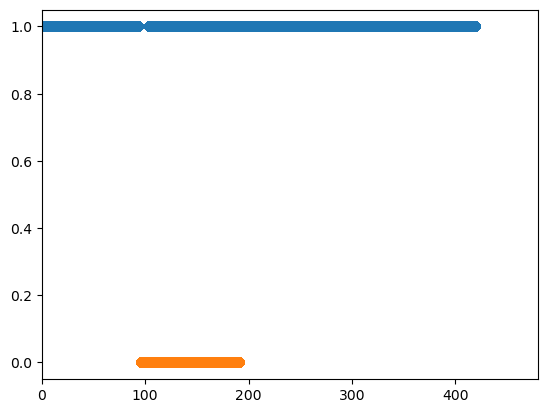

train_X.shape: (4458543, 160), train_y.shape: (4458543, 4)
valid_X.shape: (1040765, 160), valid_y.shape: (1040765, 4)
Training until validation scores don't improve for 100 rounds
[500]	train's l1: 6.27372	valid's l1: 6.982
[1000]	train's l1: 6.21571	valid's l1: 6.92056
[1500]	train's l1: 6.17465	valid's l1: 6.87737
[2000]	train's l1: 6.14143	valid's l1: 6.84328
[2500]	train's l1: 6.11118	valid's l1: 6.81184
[3000]	train's l1: 6.0816	valid's l1: 6.78075
[3500]	train's l1: 6.05359	valid's l1: 6.75181
[4000]	train's l1: 6.02793	valid's l1: 6.72537
[4500]	train's l1: 6.00305	valid's l1: 6.69913
[5000]	train's l1: 5.97829	valid's l1: 6.67302
[5500]	train's l1: 5.95492	valid's l1: 6.6479
[6000]	train's l1: 5.93295	valid's l1: 6.62436
Did not meet early stopping. Best iteration is:
[6000]	train's l1: 5.93295	valid's l1: 6.62436


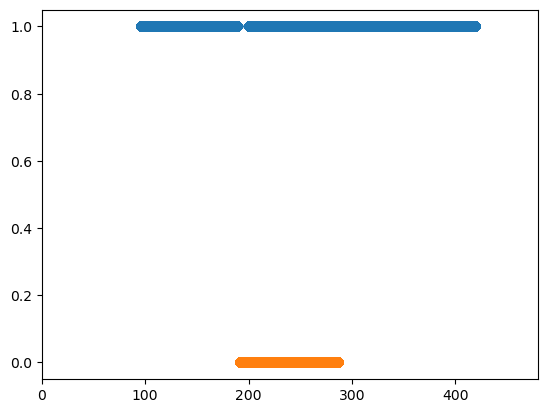

train_X.shape: (3433594, 160), train_y.shape: (3433594, 4)
valid_X.shape: (1050720, 160), valid_y.shape: (1050720, 4)
Training until validation scores don't improve for 100 rounds
[500]	train's l1: 6.42332	valid's l1: 6.32605
[1000]	train's l1: 6.35395	valid's l1: 6.26524
[1500]	train's l1: 6.30608	valid's l1: 6.22351
[2000]	train's l1: 6.26404	valid's l1: 6.18689
[2500]	train's l1: 6.22536	valid's l1: 6.15326
[3000]	train's l1: 6.18889	valid's l1: 6.12116
[3500]	train's l1: 6.15478	valid's l1: 6.09164
[4000]	train's l1: 6.12398	valid's l1: 6.06466
[4500]	train's l1: 6.09447	valid's l1: 6.03904
[5000]	train's l1: 6.06496	valid's l1: 6.01335
[5500]	train's l1: 6.03695	valid's l1: 5.98864
[6000]	train's l1: 6.01135	valid's l1: 5.9662
Did not meet early stopping. Best iteration is:
[6000]	train's l1: 6.01135	valid's l1: 5.9662


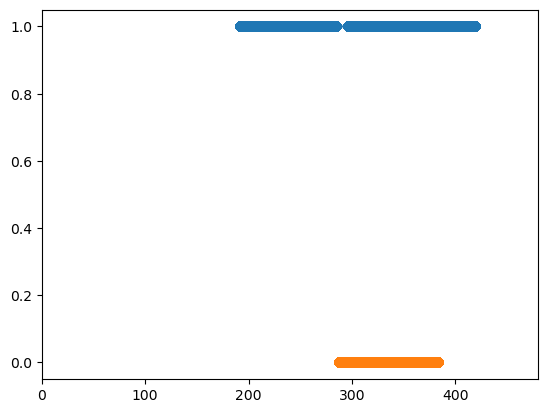

train_X.shape: (2392719, 160), train_y.shape: (2392719, 4)
valid_X.shape: (1055559, 160), valid_y.shape: (1055559, 4)
Training until validation scores don't improve for 100 rounds
[500]	train's l1: 6.26531	valid's l1: 6.21501
[1000]	train's l1: 6.18195	valid's l1: 6.13803
[1500]	train's l1: 6.12175	valid's l1: 6.08373
[2000]	train's l1: 6.06882	valid's l1: 6.03616
[2500]	train's l1: 6.02097	valid's l1: 5.99365
[3000]	train's l1: 5.97616	valid's l1: 5.95337
[3500]	train's l1: 5.93457	valid's l1: 5.91585
[4000]	train's l1: 5.89683	valid's l1: 5.88225
[4500]	train's l1: 5.85812	valid's l1: 5.84776
[5000]	train's l1: 5.82421	valid's l1: 5.81741
[5500]	train's l1: 5.79059	valid's l1: 5.7874
[6000]	train's l1: 5.75992	valid's l1: 5.75994
Did not meet early stopping. Best iteration is:
[6000]	train's l1: 5.75992	valid's l1: 5.75994


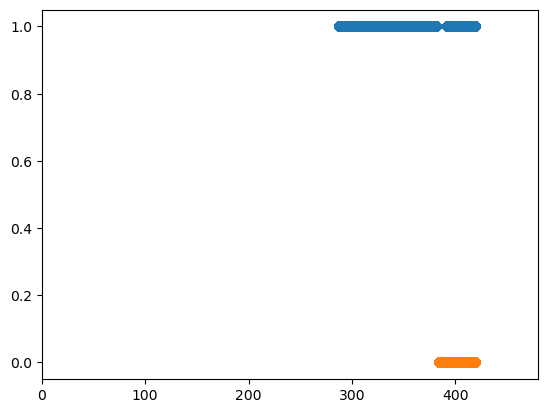

train_X.shape: (1341559, 160), train_y.shape: (1341559, 4)
valid_X.shape: (395945, 160), valid_y.shape: (395945, 4)
Training until validation scores don't improve for 100 rounds
[500]	train's l1: 6.14894	valid's l1: 6.2146
[1000]	train's l1: 6.02502	valid's l1: 6.11277
[1500]	train's l1: 5.93645	valid's l1: 6.04169
[2000]	train's l1: 5.8602	valid's l1: 5.98022
[2500]	train's l1: 5.79073	valid's l1: 5.92461
[3000]	train's l1: 5.72891	valid's l1: 5.87464
[3500]	train's l1: 5.66954	valid's l1: 5.82635
[4000]	train's l1: 5.61565	valid's l1: 5.78272
[4500]	train's l1: 5.56556	valid's l1: 5.74229
[5000]	train's l1: 5.51751	valid's l1: 5.70357
[5500]	train's l1: 5.4749	valid's l1: 5.66878
[6000]	train's l1: 5.43628	valid's l1: 5.63723
Did not meet early stopping. Best iteration is:
[6000]	train's l1: 5.43628	valid's l1: 5.63723


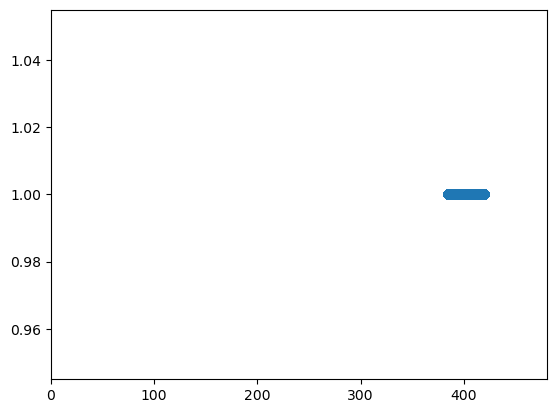

train_X.shape: (395945, 160), train_y.shape: (395945, 4)
valid_X.shape: (0, 160), valid_y.shape: (0, 4)


ValueError: Input data must be 2 dimensional and non empty.

In [10]:
params = {
        "objective": "mae",
        "n_estimators": 6000,
        "num_leaves": 256,
        "subsample": 0.6,
        "colsample_bytree": 0.8,
#         "learning_rate": 0.00871,
        "learning_rate": 0.01,
        'max_depth': 11,
        "n_jobs": 4,
        "verbosity": -1,
        "importance_type": "gain",
#         "reg_alpha": 0.1,
        "reg_alpha": 0.2,
        "reg_lambda": 3.25
    }

step = 60
gap = 0

history, oof_true, oof_pred, fimps, mean_best_iteration = train(
    dataset=train_df,
    model_params=params,
    outputs_dir=outputs_dir_path,
    step=step,
    gap=gap,
)

In [ ]:
_, ax = plt.subplots(figsize=(12, 36))
fimps['mean_fimps'].plot(kind='barh', xerr=fimps['std_fimps'], capsize=3, ax=ax)  
plt.tight_layout()
plt.show()